In [3]:
import numpy as np
import osmnx as ox
import networkx as nx 
import pandas as pd 
import matplotlib.pyplot as plt
import copy 
import geopandas as gpd
%matplotlib inline

## Download graph

In [146]:
#Файл можно скачать на сайте OpenStreetMap --> Экспорт --> Навестись на область карты --> кликнуть Overpass Api
# osm_file_path = "/home/igoreshka/Downloads/map (2)"
# graph = ox.graph_from_xml(osm_file_path, simplify=True)

city_name = 'Vladivostok, Russia'
graph = ox.graph_from_place(city_name)

ox.plot_graph(ox.project_graph(graph))

(<Figure size 800x800 with 1 Axes>, <Axes: >)

## Graph description

In [44]:
# for u, v, key, edge_data in graph.edges(keys=True, data=True):
#     if 'length' not in edge_data.keys() :
#         print(edge_data)

nodes_x_y = []
for node in graph.nodes():
    info_node = graph.nodes[node]
    nodes_x_y.append((info_node['x'],info_node['y']))
nodes_x_y = np.array(nodes_x_y)
[graph_min_x,graph_min_y] = np.min(nodes_x_y,axis=0)
[graph_max_x ,graph_max_y] = np.max(nodes_x_y,axis=0)
print("min_x ,min_y =", graph_min_x,graph_min_y)
print("max_x ,max_y =",graph_max_x ,graph_max_y)

min_x ,min_y = 131.8413495 43.0578806
max_x ,max_y = 132.2312957 43.2880725


In [ ]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    print(edge_data.keys())


## Данные о жителях

С openstreetmap :

In [134]:

# buildings = ox.features.features_from_bbox( graph_max_y ,graph_min_y , graph_max_x , graph_min_x ,tags={'building':True}) #Примерно то что нужно
# buildings = ox.features.features_from_address(city_name , tags={'building':True}) тоже некорректно выдает город
# buildings = ox.geometries.geometries_from_address(city_name , tags={'building':True}) Устарело

In [135]:
# coords = np.array(buildings['geometry'].get_coordinates())
# [min_x,min_y] = np.min(coords,axis=0)
# [max_x ,max_y] = np.max(coords,axis=0)
# print("min_x ,min_y =", min_x,min_y)
# print("max_x ,max_y =",max_x ,max_y)

In [136]:
# plt.scatter(coords[:,0],coords[:,1])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title(city_name)
# plt.show()

Из датасета (вся Россия)

In [53]:
file_path = '~/Downloads/data.csv'
buildings_2 = pd.read_csv(file_path)

/tmp/ipykernel_4767/4268506079.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  buildings_2 = pd.read_csv(file_path)


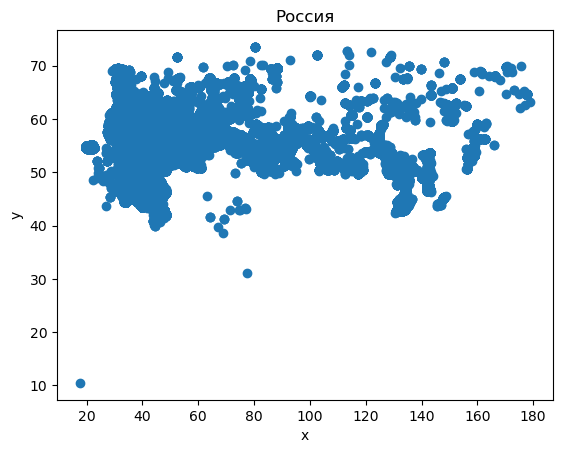

In [54]:
plt.scatter(buildings_2['longitude'], buildings_2['latitude'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Россия')
plt.show()

Отрежем конкретный город

In [132]:
builds_filtered = buildings_2[ buildings_2['longitude'] >= graph_min_x ][ buildings_2['longitude'] <=graph_max_x ][ buildings_2['latitude'] >= graph_min_y ][ buildings_2['latitude'] <=graph_max_y ]
builds_filtered = builds_filtered[builds_filtered['appartments'] > 0]

/tmp/ipykernel_4767/3022995213.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  builds_filtered = buildings_2[ buildings_2['longitude'] >= graph_min_x ][ buildings_2['longitude'] <=graph_max_x ][ buildings_2['latitude'] >= graph_min_y ][ buildings_2['latitude'] <=graph_max_y ]


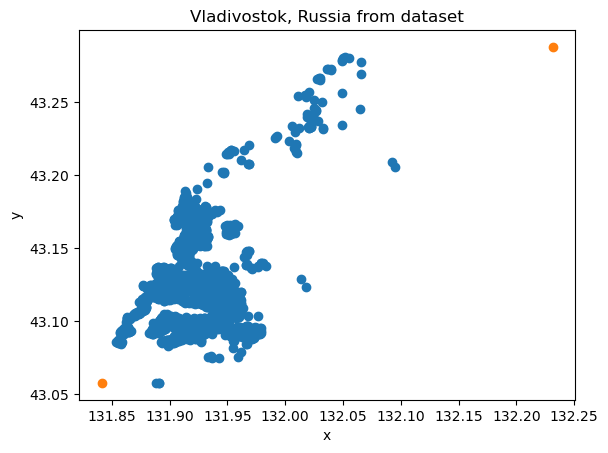

In [137]:

plt.scatter(builds_filtered['longitude'], builds_filtered['latitude'])
plt.scatter([graph_min_x , graph_max_x],[graph_min_y, graph_max_y])
plt.xlabel('x')
plt.ylabel('y')
plt.title(city_name + ' from dataset')
plt.show()

## Добавим разбиение города по районам (определяемых числом жителей)

In [138]:
builds_lon = (graph_min_x,graph_max_x)
builds_lat = (graph_min_y , graph_max_y)
builds_f = builds_filtered[['latitude' , 'longitude', 'appartments']]
builds_f.head()

latitude   longitude  appartments
673   43.163696  131.954942        170.0
766   43.095322  131.969702         44.0
1228  43.166774  131.906963         83.0
1260  43.240519  132.022873          4.0
1353  43.143591  131.909721         54.0

In [139]:
builds_f.shape

(1985, 3)

In [140]:
def get_cell(df, lon, lat):
    return df[(df['longitude'] > lon[0]) & (df['longitude'] < lon[1]) & (df['latitude'] > lat[0]) & (df['latitude'] < lat[1])]
get_cell(builds_f,builds_lon,builds_lat).head()

latitude   longitude  appartments
673   43.163696  131.954942        170.0
766   43.095322  131.969702         44.0
1228  43.166774  131.906963         83.0
1260  43.240519  132.022873          4.0
1353  43.143591  131.909721         54.0

In [141]:
borders_lon, borders_lat = [], []
MIN_COUNT = 10
MAX_SUM = 5000
def split(df, n, lon, lat):
    global borders_lon, borders_lat
    cells = []
    lons = np.linspace(*lon, n[0]+1)
    lats = np.linspace(*lat, n[1]+1)
    
    for lon in zip(lons[:-1], lons[1:]):
        for lat in zip(lats[:-1], lats[1:]):
            cell_jobs = get_cell(builds_f, lon, lat)
            if cell_jobs.shape[0] > 0:
                if cell_jobs['appartments'].to_numpy().sum() > MAX_SUM and cell_jobs.shape[0] > MIN_COUNT:
                    cells += split(cell_jobs, n, lon, lat)
                else:
                    borders_lon += [*lon, *lon[::-1], lon[0], None]
                    borders_lat += [lat[0], lat[0], lat[1], lat[1], lat[0], None]
                    cells.append(cell_jobs)
    return cells
        
cells = split(builds_f, (2,2), builds_lon,builds_lat)

In [142]:
for j in cells :
    print(j.shape[0], j['appartments'].to_numpy().sum())

9 591.0
40 3241.0
6 377.0
17 643.0
50 3045.0
26 1523.0
19 795.0
36 4240.0
18 489.0
36 3765.0
38 2271.0
27 1953.0
50 3777.0
13 486.0
32 2448.0
77 4807.0
64 2725.0
21 1139.0
47 3136.0
20 3418.0
26 2626.0
57 3995.0
2 151.0
25 2271.0
10 439.0
12 1646.0
32 3911.0
24 3163.0
29 3952.0
51 4454.0
60 3431.0
52 2584.0
53 4654.0
36 2885.0
12 1231.0
21 1532.0
16 1602.0
11 995.0
1 72.0
24 2269.0
32 2411.0
54 3774.0
20 1922.0
21 2242.0
8 662.0
3 270.0
64 4077.0
36 3325.0
21 1020.0
28 1377.0
41 4002.0
16 2215.0
15 2386.0
39 3752.0
25 2321.0
11 1288.0
8 958.0
3 174.0
27 2284.0
31 2574.0
18 3481.0
15 1531.0
28 3443.0
12 903.0
10 2231.0
1 150.0
10 1978.0
3 926.0
7 584.0
2 116.0
36 4164.0
2 300.0
31 2523.0
8 1852.0
8 1049.0
2 48.0
1 4.0
33 1903.0
40 1212.0
15 434.0


Центро

## Нарисуем получившиеся районы

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

point = []
for j in cells :
    point.append(j[['longitude','latitude']].to_numpy())

plt.figure()

num_regions = len(point)
print(num_regions)
color_map = cm.get_cmap('tab20')

for i, region_points in enumerate(point):
    x_coords, y_coords = zip(*region_points)
    color = color_map(i / num_regions) 
    plt.scatter(x_coords, y_coords, color=color) #, label=f'Район {i+1}')

plt.legend()
plt.show()

80


/tmp/ipykernel_4767/3384316361.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## Получим центры масс районов 

In [182]:
regions = np.array([ j[['latitude' ,'longitude' ,'appartments']].to_numpy() for j in cells])
centroids = []
for region in regions :
    mass = np.sum(region[:,2])
    centre_mass= [np.sum(region[:,1]*region[:,2])/mass,np.sum(region[:,0]*region[:,2])/mass , mass]
    centroids.append(centre_mass)
centroids[0]

/tmp/ipykernel_4767/2912894043.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  regions = np.array([ j[['latitude' ,'longitude' ,'appartments']].to_numpy() for j in cells])


[131.85591257360406, 43.08531095262267, 591.0]

Отрисуем, что получилось

In [145]:
plt.figure()
num_regions = len(point)
color_map = cm.get_cmap('tab20')
for i, region_points in enumerate(point):
    x_coords, y_coords = zip(*region_points)
    color = color_map(i / num_regions) 
    plt.scatter(x_coords, y_coords, color=color) #, label=f'Район {i+1}')

for i, region_points in enumerate(centroids):
    [x_coords, y_coords] = region_points[:2]
    plt.scatter(x_coords, y_coords, color='black') #, label=f'Район {i+1}')
plt.legend()
plt.show()

/tmp/ipykernel_4767/3139849830.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [153]:
print(centroids[:3])

[[131.85591257360406, 43.08531095262267, 591.0], [131.86089960043196, 43.09291035205184, 3241.0], [131.8634023209549, 43.1023293342175, 377.0]]


## Найдем ближайшие дороги к центроидам

In [158]:
nodes = []
for node in graph.nodes():
    nodes.append({'id' :node ,'x':graph.nodes[node]['x'], 'y':graph.nodes[node]['y']})

In [ ]:
centroids_with_neighbors = centroids
for i,c in enumerate(centroids) :
    neighbors = []
    for node in nodes :
        dist = (c[0]-node['x'] )**2 + (c[1]-node['y'] )**2
        neighbors.append((node['id'] , dist))
    neighbors = np.array(neighbors)
    # 2 neighbors :
    # print(neighbors)
    centroids_neighbors = []
    values = neighbors[:,1]
    for j in range(2) :
        min_id = np.argmin(values)
        min_value = neighbors[min_id]
        centroids_neighbors.append(min_value[0])
        values = np.delete(values,min_id)
    centroids_with_neighbors[i].append(centroids_neighbors)
    # print(i)
    


Нарисуем несколько центроид с их соседями

In [188]:
plt.figure()

centroids_array = centroids_with_neighbors[:10]
num_regions = len(centroids_array)
color_map = cm.get_cmap('tab20')
for i, centroid in enumerate(centroids_array):
    for j in centroid[3] :
        x_coords, y_coords = graph.nodes[j]['x'],graph.nodes[j]['y']
        color = color_map(i / num_regions) 
        plt.scatter(x_coords, y_coords, color=color) #, label=f'Район {i+1}')

# for i, region_points in enumerate(centroids_array):
#     [x_coords, y_coords] = region_points[:2]
#     plt.scatter(x_coords, y_coords, color='black') #, label=f'Район {i+1}')
plt.legend()
plt.show()

/tmp/ipykernel_4767/2064467723.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## Добавим центроиды в граф и соединим их с ближайшими дорогами

In [ ]:
for name in graph.nodes() :
    print(graph.nodes[name])

In [197]:
for i,vertex in enumerate(centroids_with_neighbors):
    graph.add_node((vertex[1],vertex[0],vertex[2],i))

In [212]:
graph.add_node(1488 ,x=21,y=213, attr={'test':3}) # опа работает

In [203]:
print(graph.nodes[10948955895])

{'y': 43.2099551, 'x': 132.0531842, 'street_count': 1}


In [213]:
for node in graph.nodes() :
    print(graph.nodes[node])

{'y': 43.1147702, 'x': 131.9014618, 'street_count': 3}
{'y': 43.1135861, 'x': 131.9119956, 'highway': 'traffic_signals', 'street_count': 3}
{'y': 43.1121599, 'x': 131.9245959, 'street_count': 5}
{'y': 43.104782, 'x': 131.9365497, 'street_count': 3}
{'y': 43.104179, 'x': 131.9368581, 'street_count': 4}
{'y': 43.1045283, 'x': 131.9377767, 'street_count': 4}
{'y': 43.1127183, 'x': 131.936218, 'street_count': 3}
{'y': 43.1292952, 'x': 131.9410707, 'highway': 'traffic_signals', 'street_count': 3}
{'y': 43.1293472, 'x': 131.9408892, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 43.1306399, 'x': 131.9385441, 'street_count': 3}
{'y': 43.1339216, 'x': 131.9360109, 'street_count': 4}
{'y': 43.1360531, 'x': 131.9359956, 'street_count': 3}
{'y': 43.1372098, 'x': 131.9309641, 'street_count': 3}
{'y': 43.136801, 'x': 131.9257194, 'street_count': 3}
{'y': 43.1368336, 'x': 131.9190923, 'street_count': 4}
{'y': 43.1373418, 'x': 131.9175363, 'street_count': 3}
{'y': 43.1374055, 'x': 131.9171986

## Данные о компаниях

In [1]:
# import xml.etree.ElementTree as ET
# def print_xml_tree(elem, level=0):
#     indent = '  ' * level
#     print(f"{indent}{elem.tag} : {elem.attrib}")
#     for child in elem:
#         print_xml_tree(child, level + 1)
# xml_file = '/home/igoreshka/Desktop/VO_OTKRDAN_3_9965_9965_20230625_0a8950a3-08fc-4ec3-afa5-e3febc99b2d7.xml'
# tree = ET.parse(xml_file)
# root = tree.getroot()
# print_xml_tree(root)

In [117]:
emp = pd.read_csv('./data/emps.csv', sep='\t')
emp[:2]

Unnamed: 0.1  Unnamed: 0                                       name  \
0             0           0   Филиал № 1 ООО "МЕГАКОМ" В Г.ВЛАДИВОСТОК   
1             1           1                Филиал ООО "Риквэст-Сервис"   

                                                 cat  \
0                        Торговля оптовая напитками…   
1  Стирка и химическая чистка текстильных и мехов...   

                                             address  emp  vac        lat  \
0  690039, г Владивосток, ул Русская, д. 46, корп. Б   57    3  43.166235   
1    690088, г Владивосток, ш Военное, д. 1, корп. А   93    2  43.132991   

          lon        district  
0  131.913458       Советский  
1  131.915460  Первореченский

## По разбиениям строим кореспоненции

In [299]:
L, W = {}, {}
# res_total = sum(cell_res['appartments'].to_numpy().sum() for cell_res in cells )
# print(res_total)
for cell_emp, _, cell_res in cells:
    L[cell_emp.nearest_id] = max(1, cell_emp.emp.sum())
#     W[cell_res.nearest_id] = int(cell_res.area.sum() / res_total * emp_total)
    # use one node for source and sink: division by zero in sinkhorn 
    W[cell_emp.nearest_id] = max(10, int(cell_res.area.sum() / res_total * emp_total))


12734.0


In [ ]:
L, W = {}, {}
res_total = sum(cell_res.area.sum() for _, _, cell_res in cells )
emp_total = sum(cell_emp.emp.sum() for cell_emp, _, _ in cells )
print(emp_total, res_total)
for cell_emp, _, cell_res in cells:
    L[cell_emp.nearest_id] = max(1, cell_emp.emp.sum())
#     W[cell_res.nearest_id] = int(cell_res.area.sum() / res_total * emp_total)
    # use one node for source and sink: division by zero in sinkhorn 
    W[cell_emp.nearest_id] = max(10, int(cell_res.area.sum() / res_total * emp_total))

    
del W[None]
del L[None]

for k, v in W.items():
    W[k] -= min(v-10, - sum(L.values()) + sum(W.values()), 100)

print(sum(L.values()), sum(W.values()))

trip_nodes, Ll, Wl = [], [], []
for k in L.keys() | W.keys():
    trip_nodes.append(k)
    Ll.append(L[k] if k in L else 0)
    Wl.append(W[k] if k in W else 0)

## Delete small roads

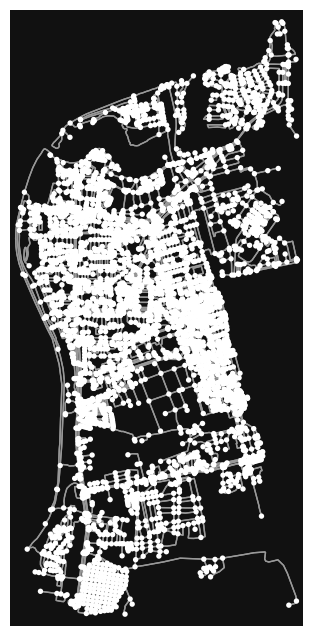

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

result_graph = copy.deepcopy(graph)

# Какие типы дорог хотим оставить

need_keys = ['length']
# highway_types = ["motorway", "trunk", "primary", "secondary",'service']

edges_to_remove = []
for u, v, key, edge_data in result_graph.edges(keys=True, data=True):
    # KEYS FILTER
    for need_key in need_keys :
        if need_key not in edge_data.keys() :
            edges_to_remove.append((u, v, key))
            break
    # HIGHWAY FILTER
    # if 'highway' not in edge_data.keys() :
    #     edges_to_remove.append((u, v, key))
    # else :
    #     if type(edge_data['highway']) == type(""):
    #         if edge_data['highway'] not in highway_types :
    #             edges_to_remove.append((u, v, key))
    #     else :
    #         for highway_type in edge_data['highway'] :
    #             if highway_type not in highway_types :
    #                 edges_to_remove.append((u, v, key))
    #                 break
for u, v, key in set(edges_to_remove):
    result_graph.remove_edge(u, v, key)

# Получение списка вершин без ребер
isolated_nodes = [node for node in result_graph.nodes() if result_graph.degree(node) == 0]

# Удаление вершин без ребер
result_graph.remove_nodes_from(isolated_nodes)

ox.plot_graph(ox.project_graph(result_graph))

## Convert result graph to dataframe

In [4]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])
df['data'][22]

{'osmid': 544655999,
 'highway': 'service',
 'oneway': False,
 'reversed': False,
 'length': 30.329,
 'geometry': <LINESTRING (37.499 55.939, 37.499 55.939, 37.499 55.939, 37.499 55.939, 37....>}

In [5]:
graph_table = pd.DataFrame(result_graph.edges(data=True),columns=['init_node' , 'term_node' , 'data'])


graph_table['init_node_thru'] = graph_table['data'].apply(lambda x: True)
graph_table['term_node_thru'] = graph_table['data'].apply(lambda x: True)
# малые дороги : lanes = 1 
graph_table['capacity'] = graph_table['data'].apply(lambda x: x['lanes'] if 'lanes' in x.keys() and type(x['lanes']) != type([])  else 1.0 )

#maxspeed пока по дефолту 32 км/ч = 10 м/c --> Итоговая величина: сек
def getfreeflowtime(x) :
    return int(x['length'])/int(x['maxspeed'])*10/32 if 'maxspeed' in x.keys() and type(x['maxspeed']) == type("") and x['maxspeed'].isdigit() else int(x['length'])/10 
graph_table['free_flow_time'] = graph_table['data'].apply(getfreeflowtime)

# graph_table['length'] = graph_table['data'].apply(lambda x: x['length'])
# graph_table['reversed'] = graph_table['data'].apply(lambda x: x['reversed'])
# graph_table['oneway'] = graph_table['data'].apply(lambda x: x['oneway'])


graph_table.drop('data', axis=1, inplace=True)

graph_table.head(10)


init_node   term_node  init_node_thru  term_node_thru capacity  \
0   27782964  1519864204            True            True      1.0   
1   27782964  1672913228            True            True      1.0   
2   27782964  1253720050            True            True      1.0   
3   27782964    27782988            True            True      1.0   
4   27782988  1297012762            True            True        2   
5   27782988  1297012759            True            True      1.0   
6   27782988  1516138003            True            True      1.0   
7   27782988    27782964            True            True      1.0   
8   27782989  4579295044            True            True      1.0   
9   27782989  1747383233            True            True      1.0   

   free_flow_time  
0        1.300000  
1        0.093750  
2        0.078125  
3        0.976562  
4        0.057292  
5        2.000000  
6        0.234375  
7        0.976562  
8        0.307292  
9        0.197917

array([1., 1., 1., ..., 1., 1., 1.])

## Кореспонденции
Список смежности : где находимся -->(сколько нас)--> куда хотим попасть 

In [6]:
nodes = result_graph.nodes(data=True)
nodes = np.array(nodes)
print(nodes[0][0],nodes[0][1])

27782964 {'y': 55.9477602, 'x': 37.4915544, 'street_count': 4}


In [7]:
graph_correspondences = dict()
graph_correspondences[nodes[0][0]] = {'targets' : [nodes[4][0]],'corrs' : [100]}
for i in range(1,30) :
    graph_correspondences[nodes[i][0]] = {'targets' : [nodes[i-1][0]],'corrs' : [100]}
print(graph_correspondences)

{27782964: {'targets': [27783036], 'corrs': [100]}, 27782988: {'targets': [27782964], 'corrs': [100]}, 27782989: {'targets': [27782988], 'corrs': [100]}, 27783013: {'targets': [27782989], 'corrs': [100]}, 27783036: {'targets': [27783013], 'corrs': [100]}, 60450985: {'targets': [27783036], 'corrs': [100]}, 60450989: {'targets': [60450985], 'corrs': [100]}, 60450990: {'targets': [60450989], 'corrs': [100]}, 60452055: {'targets': [60450990], 'corrs': [100]}, 60452056: {'targets': [60452055], 'corrs': [100]}, 60452057: {'targets': [60452056], 'corrs': [100]}, 60452060: {'targets': [60452057], 'corrs': [100]}, 60452061: {'targets': [60452060], 'corrs': [100]}, 60452064: {'targets': [60452061], 'corrs': [100]}, 60452074: {'targets': [60452064], 'corrs': [100]}, 60452076: {'targets': [60452074], 'corrs': [100]}, 60452077: {'targets': [60452076], 'corrs': [100]}, 60453069: {'targets': [60452077], 'corrs': [100]}, 60453072: {'targets': [60453069], 'corrs': [100]}, 66387088: {'targets': [6045307

## Для теста

In [8]:
graph_data = {
    'nodes number': len(result_graph.nodes(data=False))  , 
    'links number' : len(result_graph.edges(data=False)) , 
    'zones number' :  len(graph_correspondences),
    'graph_table': graph_table
}
graph_correspondences
total_od_flow = 100